In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten
from keras import callbacks, optimizers

import os
import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
# our parameters
train_data_pth = os.getcwd() + '/../data_raw/train/'
validation_data_pth = os.getcwd() + '/../data_raw/validation/'
log_pth = os.getcwd() + '/../data/logs/'
n_train_samples = 1800
n_validation_samples = 100
n_epochs = 10
batch_size = 20
n_classes = 4
img_width, img_height = 80, 80
input_shape = (img_width, img_height, 3)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_pth,
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

Found 1800 images belonging to 4 classes.


In [4]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_pth, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

Found 687 images belonging to 4 classes.


In [5]:
class_weights = {0: 1.4, 1: 1, 2: 2.3, 3: 2.3}

In [6]:
# sets up the model shape
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [7]:
# callback for recording things to tensorboard
tbCallBack = callbacks.TensorBoard(log_dir=log_pth, 
                                   histogram_freq=1,
                                   write_graph=True, 
                                   write_images=True, 
                                   embeddings_freq=1)

In [8]:
# runs the model
model.fit_generator(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=int(n_train_samples / batch_size),
    validation_steps=int(n_validation_samples / batch_size), 
    epochs=n_epochs,
    class_weight = class_weights,
    callbacks=[tbCallBack]
)

INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflo

In [9]:
folders = ['bart', 'hommer', 'lisa', 'marge']
y = []
y_hat = []

for i in range(len(folders)):
    files = glob.glob('/home/matt/Repos/simpsons/data_raw/color/validation/' + folders[i] + '/*.jpg')
    for f in files:
        img = Image.open(f)
        img = img.resize((img_width, img_height), Image.ANTIALIAS)
        y.append(i)
        y_hat.append(model.predict_classes(np.expand_dims(np.asarray(img), axis=0))[0])

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


In [10]:
sum(1 for i, j in zip(y_hat, y) if i == j) / float(len(y_hat))

0.8049490538573508

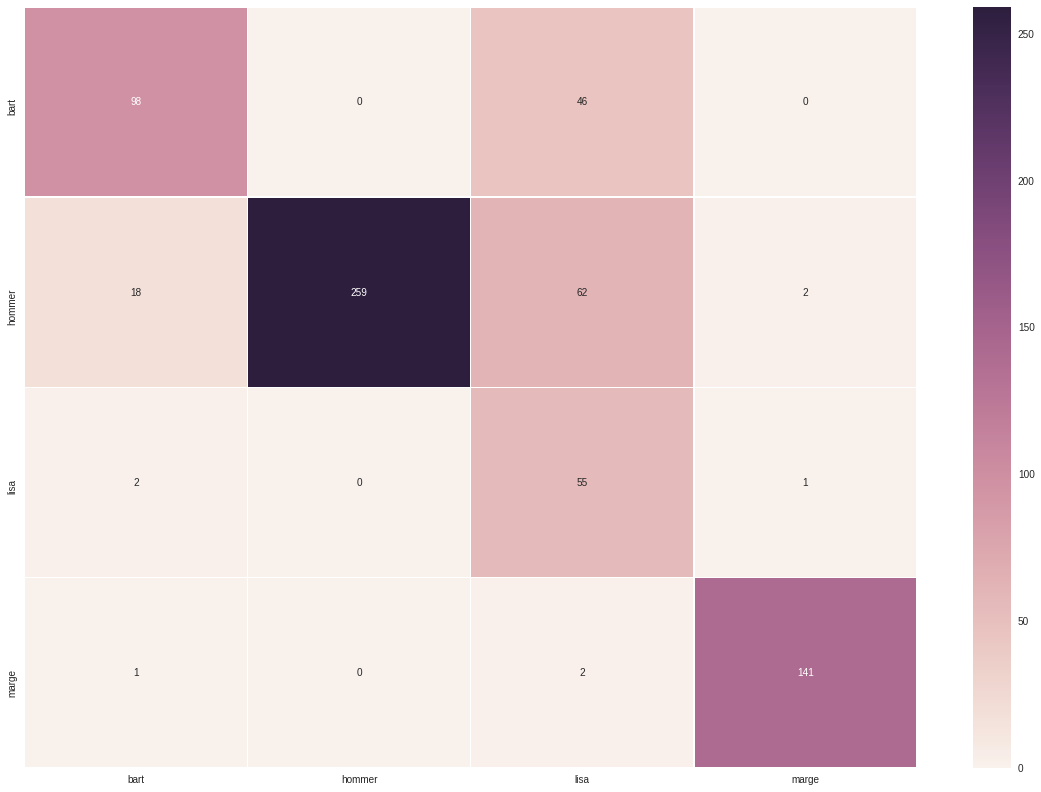

In [11]:
conf_matrix = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
for i in range(len(y)):
    conf_matrix[y[i]][y_hat[i]] += 1

df_cm = pd.DataFrame(conf_matrix, index = ['bart', 'hommer', 'lisa', 'marge'],
                  columns = ['bart', 'hommer', 'lisa', 'marge'])

plt.figure(figsize = (20, 14))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt='g')